# Time-Series CIA-3 Project

**Team Members:**
- **Aman Singh** (Register Number: 23122105)
- **Sarnalika Paul** (Register Number: 23122130)


## Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

**Dataset Description**

The dataset records the monthly champagne sales for Perrin Frères from January 1964 to September 1972, capturing the sales figures over 105 months. It contains two columns:  

Month: Represents the month and year in the format "YYYY-MM". There are 105 unique entries in this column, spanning the period from January 1964 to September 1972. Each entry corresponds to a specific month, making this a categorical column with no missing values.  

Perrin Frères monthly champagne sales (millions ?64-?72): Records the monthly sales of champagne in millions. The exact unit might represent currency from 1964 to 1972 (possibly British pounds or French francs). This column is numeric, with an integer data type (int64), and no missing values. The sales figures vary significantly, ranging from 1,413 to 13,916 units sold in a month.  

**Dataset Objective**  
The objective is to analyze and forcast based only on the sales value overtime  

## Loading the dataset

In [4]:
df = pd.read_csv('perrin-freres-monthly-champagne-.csv', encoding='ISO-8859-1')
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


## Exploratory data analysis

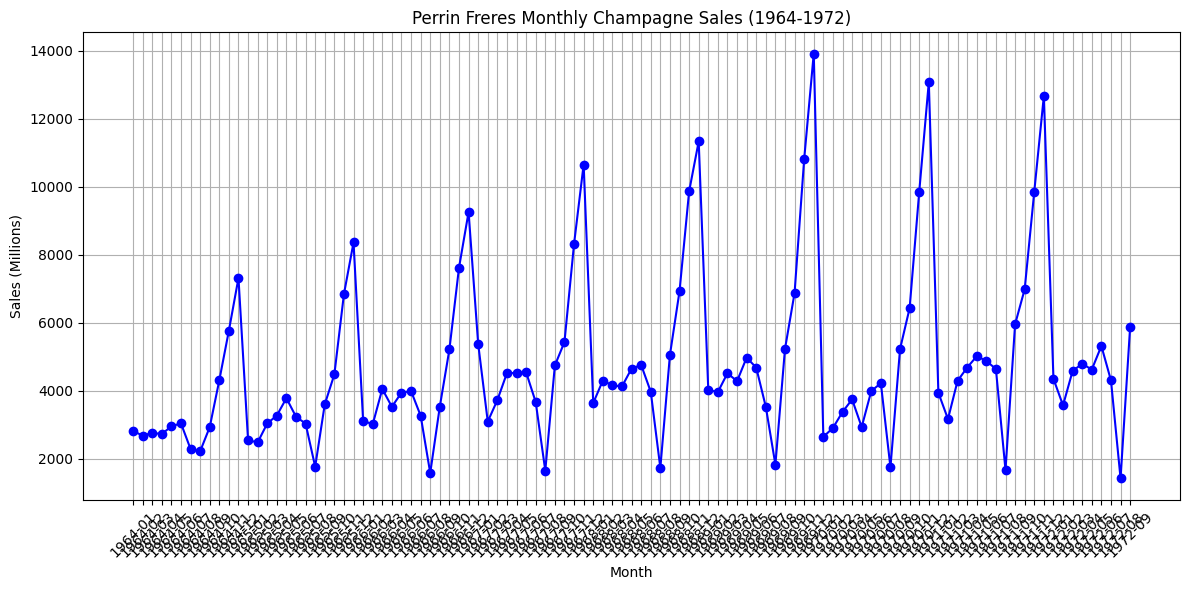

In [5]:
# Bar Chart
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Perrin Freres monthly champagne sales millions ?64-?72'], marker='o', color='b')
plt.title('Perrin Freres Monthly Champagne Sales (1964-1972)')
plt.xlabel('Month')
plt.ylabel('Sales (Millions)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


**Interpretation:**    
There are visible fluctuations in sales, with some months showing sharp increases or decreases.  
A few clear peaks can be seen, potentially due to seasonal demand (e.g., during holidays or celebrations).
Overall, the trend suggests variability with no immediate long-term upward or downward trend, though certain months show significant sales spikes.

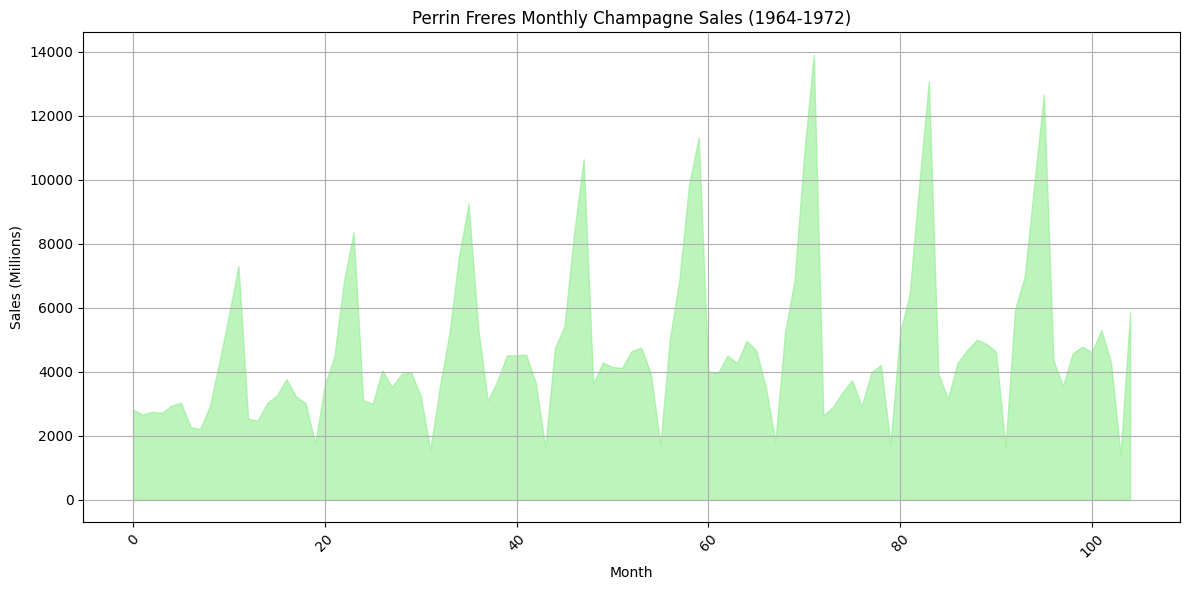

In [6]:
# Area Plot
plt.figure(figsize=(12, 6))
plt.fill_between(df.index, df['Perrin Freres monthly champagne sales millions ?64-?72'], color='lightgreen', alpha=0.6)
plt.title('Perrin Freres Monthly Champagne Sales (1964-1972)')
plt.xlabel('Month')
plt.ylabel('Sales (Millions)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


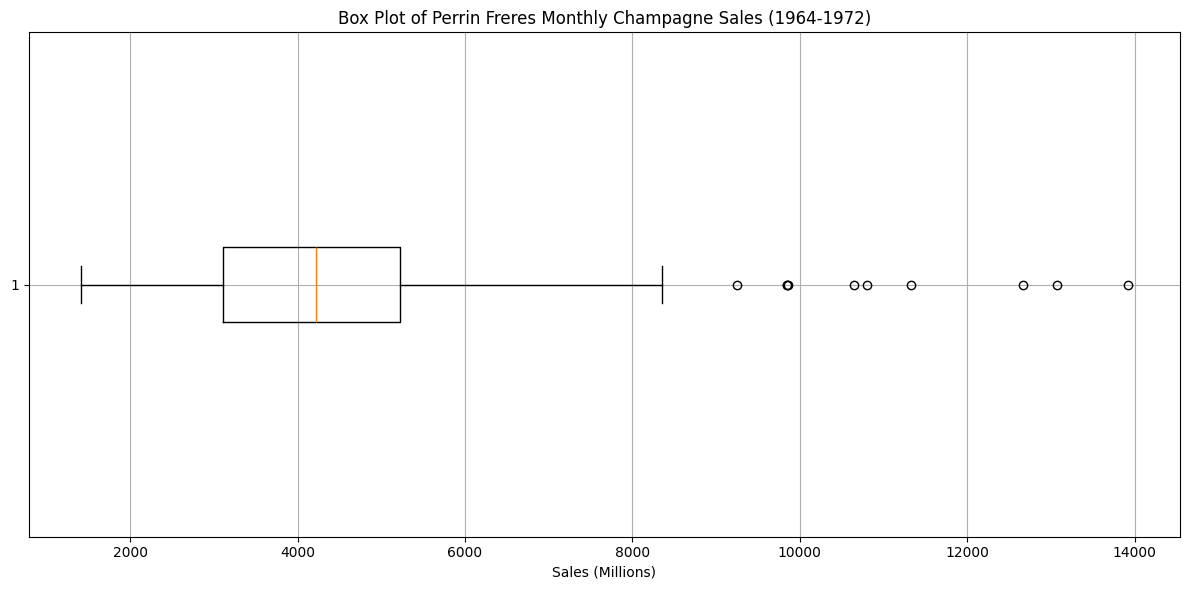

In [7]:
# Box Plot
plt.figure(figsize=(12, 6))
plt.boxplot(df['Perrin Freres monthly champagne sales millions ?64-?72'], vert=False)
plt.title('Box Plot of Perrin Freres Monthly Champagne Sales (1964-1972)')
plt.xlabel('Sales (Millions)')
plt.grid()
plt.tight_layout()
plt.show()


**Interpretation:**  
The interquartile range (IQR) shows the middle 50% of sales values are between roughly 3,100 and 5,200 million.  
There are several outliers at the upper end (beyond 7,500), indicating occasional spikes in sales, which might be due to special events or high-demand periods.
The median value of sales is around 4,217 million, which aligns with the general distribution seen in the histogram.

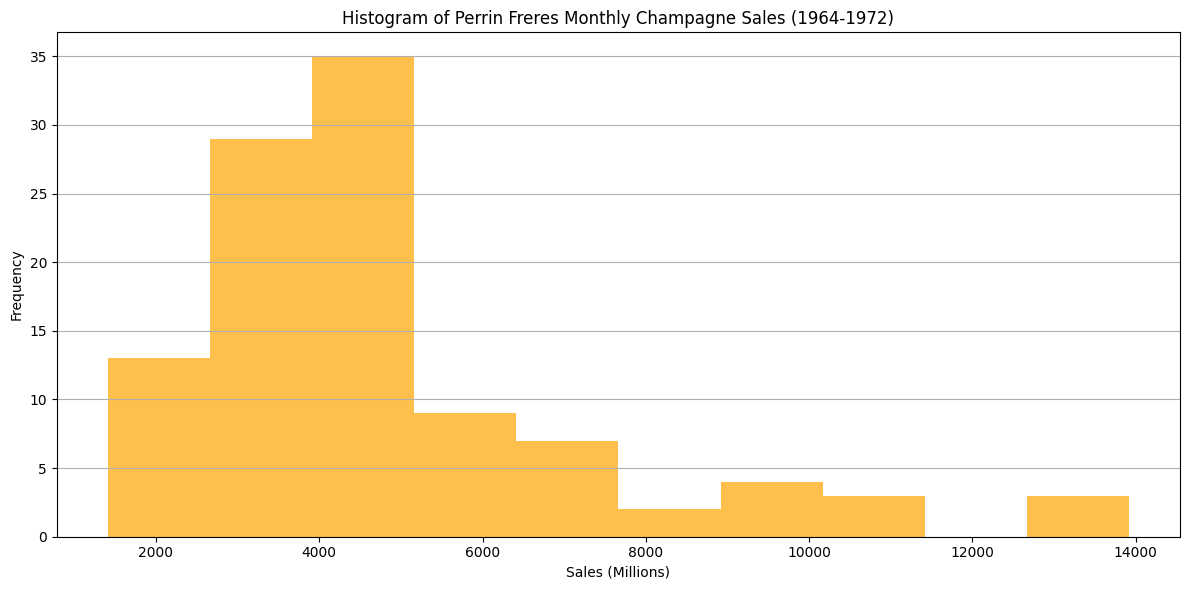

In [8]:
# Histogram
plt.figure(figsize=(12, 6))
plt.hist(df['Perrin Freres monthly champagne sales millions ?64-?72'], bins=10, color='orange', alpha=0.7)
plt.title('Histogram of Perrin Freres Monthly Champagne Sales (1964-1972)')
plt.xlabel('Sales (Millions)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Sales Distribution Histogram:**    
Visualization: The histogram shows the frequency distribution of champagne sales, with a smooth kernel density estimate (KDE) overlay.  
**Interpretation:**     
The sales distribution is slightly skewed to the right, meaning there are a few months with very high sales figures compared to the majority.
Most of the sales are concentrated between 3,000 and 5,000 millions, indicating a typical range.
The KDE curve suggests the presence of a long tail, where higher sales values (above 6,000) occur less frequently but still have notable instances.

## Pre-processing of the dataset

In [9]:
import seaborn as sns

In [10]:
df.sample(10)

,Month,Perrin Freres monthly champagne sales millions ?64-?72
68,1969-09,5222
46,1967-11,8314
65,1969-06,4677
47,1967-12,10651
88,1971-05,5010
84,1971-01,3934
95,1971-12,12670
27,1966-04,3523
82,1970-11,9842
28,1966-05,3937


In [11]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


Since the Column name is too large, we are renaming it to "Sales"

In [12]:
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'}, inplace=True)


In [13]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [14]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [15]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## Plotting of the sales data

<Axes: xlabel='Month'>

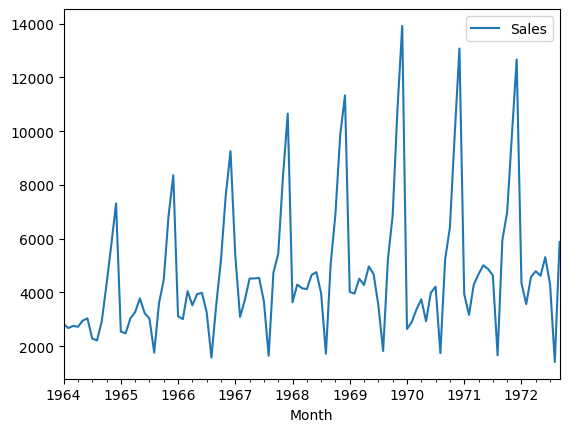

In [16]:
df.plot()

### Decomposition

In this analysis, we observe an upward trend in the sales data over time. We can utilize the `statsmodels` library to decompose this time series, breaking it down into key components: `trend`, `seasonal`, and `residual`. This process helps to identify underlying patterns and fluctuations in the data.

For our sales data, an `additive` model may be suitable if the trend appears linear and both the seasonal and trend components remain constant over time (e.g., adding a fixed increase in sales each year). However, if the sales increase at an accelerating rate (e.g., doubling sales annually), a `multiplicative` model would be more appropriate.

Based on the observed patterns in our sales data, the trend seems to be increasing at a non-linear rate, suggesting that a `multiplicative` model is the best choice for further analysis.


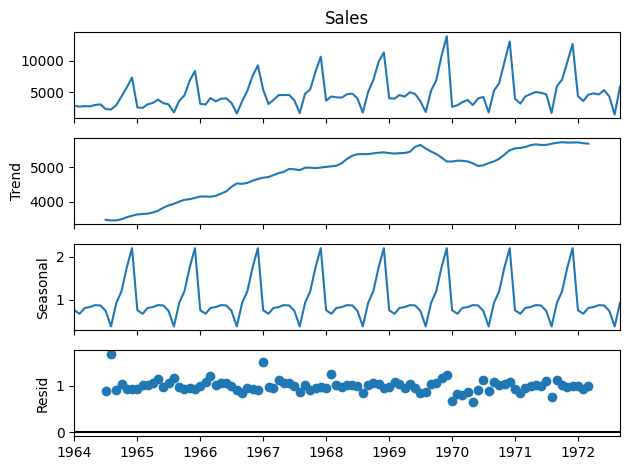

In [18]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Sales'], model='multiplicative', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()


## Interpretation of the Plot

From the plot above, we can clearly observe two key components of the time series data:

- **Seasonality**: There is a repeating pattern, indicating the presence of a seasonal component.
- **Trend**: We can also see an upward trend in the data, indicating a gradual increase in Sales over time.

Additionally, there are **irregular fluctuations**, which are random, and unpredictable changes in the data. 


### **The Augmented Dickey-Fuller (ADF) Test Hypotheses**

#### **Null Hypothesis (H₀):**
- The time series has a **unit root**, meaning it is **non-stationary**.

#### **Alternative Hypothesis (H₁):**
- The time series does **not** have a unit root, meaning it is **stationary**.

---

### **Interpretation of the Test:**
- **If the p-value is less than the significance level (e.g., 0.05)**:  
  You reject the null hypothesis (H₀) and conclude that the series is **stationary**.
  
- **If the p-value is greater than the significance level (e.g., 0.05)**:  
  You fail to reject the null hypothesis (H₀) and conclude that the series is **non-stationary**.

---



In [19]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276166
p-value : 0.36391577166024813
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


As our data has Seasonal Component with an upward trend, we will use SARIMA model first to fit our sales data

## Fitting SARIMA model

## Forecasting with SARIMA

In ARIMA, the key parameters are:
- **p** (Auto-Regressive): Incorporates past values, e.g., forecasting based on previous patterns.
- **d** (Integrated): Determines the amount of differencing applied to the data.
- **q** (Moving Average): Accounts for lagged errors.

Since our dataset has a seasonal component, we use a **SARIMA** model, adding **P**, **D**, and **Q** for the seasonal elements.

To select the best values for **p**, **d**, **q**, **P**, **D**, and **Q**, we can perform a grid search. A common method is using the **Akaike Information Criterion (AIC)**, which balances model fit and complexity—lower AIC values indicate better models.

The **`pyramid-arima`** library provides an easy way to perform this search with its **`auto_arima`** function, which automatically finds the best-fitting model based on AIC.

---


## AIC and Model Selection

The **Akaike Information Criterion (AIC)** measures how well a model fits the data while considering the overall complexity of the model. A model that fits the data exceptionally well but uses many features will receive a higher AIC score compared to a simpler model that achieves the same goodness-of-fit.

Thus, our goal is to find the model that yields the **lowest AIC value**, as this indicates a better balance between model fit and complexity.

---


In [21]:
stepwise_model = auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1486.124, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1524.662, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1507.071, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1490.517, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1488.819, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1486.804, Time=0.19 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1486.780, Time=0.48 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1485.190, Time=0.15 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1486.738, Time=0.40 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1490.003, Time=0.08 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1487.125, Time=0.18 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1487.101, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1516.612, Time=0.03 sec
 ARIMA(0,1,2)(1,1,0)[12]

## Fitting the best SARIMA model

In [22]:
import statsmodels.api as sm
# Fit the SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(df['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
forecast_sarima = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09151D+00    |proj g|=  1.56831D-01

At iterate    5    f=  7.05057D+00    |proj g|=  3.47100D-02

At iterate   10    f=  7.04847D+00    |proj g|=  2.44890D-04

At iterate   15    f=  7.04843D+00    |proj g|=  5.16684D-03

At iterate   20    f=  7.04432D+00    |proj g|=  3.83390D-02

At iterate   25    f=  7.03804D+00    |proj g|=  6.82650D-02

At iterate   30    f=  7.03424D+00    |proj g|=  2.40464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [23]:
forecast_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -738.595
Date:                             Tue, 15 Oct 2024   AIC                           1485.190
Time:                                     22:05:36   BIC                           1495.278
Sample:                                 01-01-1964   HQIC                          1489.262
                                      - 09-01-1972                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.071      3.947      0.000       0.140       0.418
ma.L1         -0.9466      0.044    -21.317      0.000      -1.034      -0.860
ar.S.L12      -0.2273      0.086     -2.652      0.008      -0.395      -0.059
sigma2      5.079e+05   5.87e+04      8.653      0.000    3.93e+05    6.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                11.08
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.26
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Checking Model Adequacy

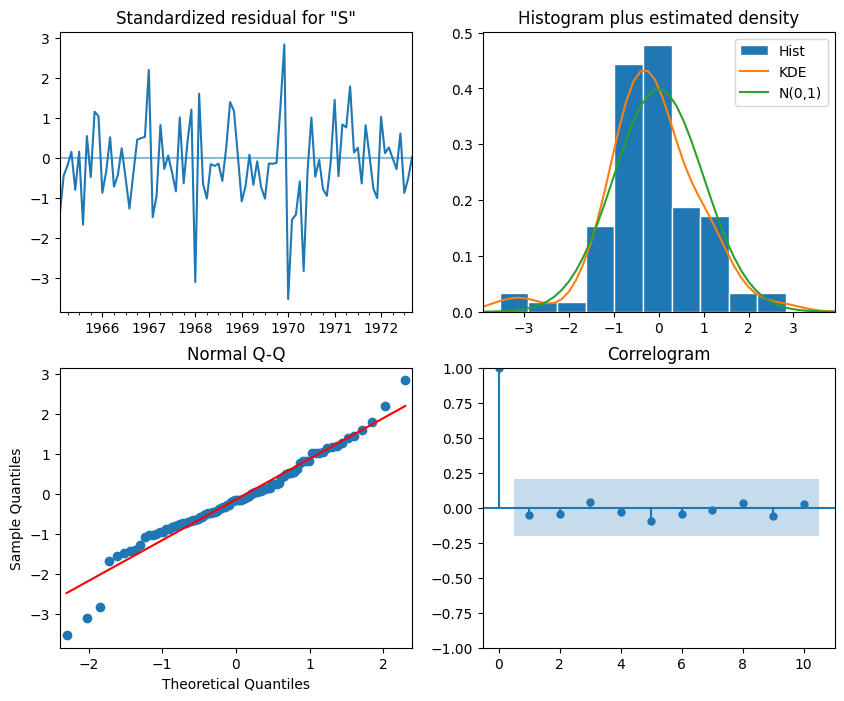

In [24]:
forecast_sarima.plot_diagnostics(figsize=(10, 8))
plt.show()

### Residual Analysis

The residuals exhibit white noise, indicating that the model has captured all relevant information from the data. The histogram and Q-Q plot confirm normality in the residuals, while the ACF plot shows no significant autocorrelations, validating the assumption that residuals are random and independent.


In [25]:
# Split into train and test sets
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]


## 5-step ahead forecast using SARIMA

/var/folders/fx/j2njn0rx1hq186_3l1d0w0pc0000gn/T/ipykernel_83655/1980875540.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=6, freq='M')[1:]  # Next 5 months (excluding the last date)


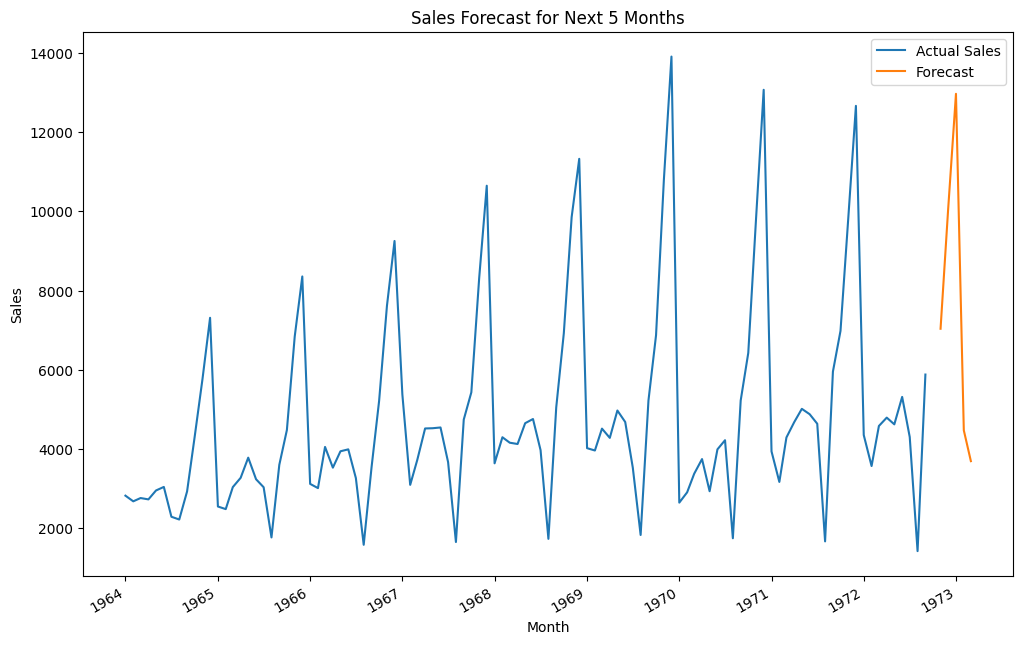

In [26]:
# Forecast the next 5 months (after the existing data)
forecast_next_5 = forecast_sarima.get_forecast(steps=5).predicted_mean

# Create a new DataFrame to hold the forecast values for the next 5 months
# Assuming your index is datetime, you can create new date indices
last_date = df.index[-1]  # Get the last date in the dataset
forecast_dates = pd.date_range(start=last_date, periods=6, freq='M')[1:]  # Next 5 months (excluding the last date)

# Create a DataFrame to hold the forecast for the next 5 months
forecast_df = pd.DataFrame({'Month': forecast_dates, 'Forecast': forecast_next_5})
forecast_df.set_index('Month', inplace=True)

# Concatenate the forecast with the original data for plotting
df_with_forecast = pd.concat([df, forecast_df])

# Plot the actual sales along with the forecast for the next 5 months
df_with_forecast[['Sales', 'Forecast']].plot(figsize=(12, 8))
plt.title('Sales Forecast for Next 5 Months')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Forecast'])
plt.show()


### SARIMA Model 5-Step Forecast

The **5-step ahead forecast** using the **SARIMA(1,1,1)(1,2,1)[12]** model shows a smooth projection that closely follows the seasonal patterns observed in the historical data. The model captures both trend and seasonality effectively, indicating a strong fit. Given that the residuals exhibit random white noise and are normally distributed, this forecast can be considered reliable for short-term predictions.


## Fitting Holt-Winters Exponential Smoothing

In [27]:
# 4. Holt-Winters Seasonal Model
model_holt = ExponentialSmoothing(df['Sales'], seasonal='mul', seasonal_periods=12).fit()
forecast_holt = model_holt.forecast(steps=5)
print("Holt-Winters Forecast:", forecast_holt)


Holt-Winters Forecast: 1972-10-01     6729.578831
1972-11-01     9840.777754
1972-12-01    12564.872490
1973-01-01     3931.628081
1973-02-01     3369.255634
Freq: MS, dtype: float64


/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 5-step ahead forecast using Holt-Winter

<Axes: xlabel='Month'>

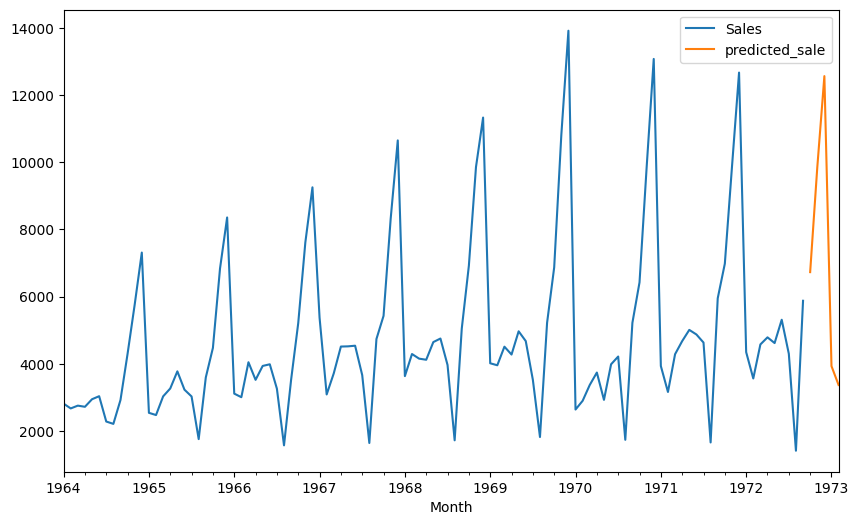

In [34]:
# 5 Steps Forcast for Holt Winter Forcast
df['Sales'].plot(legend=True, label='Sales', figsize=(10,6))


forecast_holt.plot(legend=True, label='predicted_sale')

### Holt-Winters Model 5-Step Forecast

The **5-step ahead forecast** using the **Holt-Winters Exponential Smoothing** model accurately reflects the seasonal variations and trend in the data. This model effectively captures the underlying patterns, showing a close alignment between the forecast and historical values. 

## Fitting LSTM Model

## Reasons for Choosing LSTM

We selected **Long Short-Term Memory (LSTM)** networks as an alternative model for several reasons:

### 1. Non-Linear Relationships
- **Complex Patterns**: LSTMs excel at capturing non-linear relationships in time series data, which may not be effectively modeled by linear models like SARIMA.

### 2. Long-Term Dependencies
- **Memory Capability**: LSTMs can retain information over long sequences, making them ideal for datasets with significant trends and seasonal components.

### 3. Flexibility
- **Adaptability**: LSTMs can handle various data types and patterns, offering more flexibility compared to traditional models.

### 4. Enhanced Performance
- **Robust Results**: LSTMs often outperform traditional models in complex forecasting scenarios, especially with larger datasets.

### Conclusion
Integrating LSTM into our analysis enhances our predictive capabilities, providing a comprehensive approach to forecasting electric production trends.


In [35]:
data = df['Sales'].values.astype("int")

In [30]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Create dataset function
def create_dataset(data, look_back=5):  # Set look_back to a smaller value
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Prepare the input data for LSTM
look_back = 5  # Set this to a smaller look back period
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Debugging: Print shapes of X_train and X_test
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

# Check if X_test is not empty
if X_test.size == 0:
    raise ValueError("X_test is empty. Ensure that your look_back parameter is appropriate for the dataset size.")

# Reshape data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

# Forecast next 5 months
lstm_input = data[-look_back:]  # Last look_back data points
lstm_input = lstm_input.reshape((1, look_back, 1))  # Reshape for LSTM input
forecast_lstm = []

# Ensure that the lstm_input has the right shape
if lstm_input.shape[0] == 1 and lstm_input.shape[1] == look_back and lstm_input.shape[2] == 1:
    for i in range(5):
        pred = model_lstm.predict(lstm_input)
        forecast_lstm.append(pred[0][0])
        lstm_input = np.append(lstm_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
else:
    print("Error: lstm_input has an unexpected shape:", lstm_input.shape)

# Inverse transform to get the original scale
forecast_lstm = scaler.inverse_transform(np.array(forecast_lstm).reshape(-1, 1))

print("LSTM Forecast:", forecast_lstm.flatten())


Shape of X_train: (79, 5)
Shape of Y_train: (79,)
Shape of X_test: (16, 5)
Shape of Y_test: (16,)
Epoch 1/100


/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 - 1s - 6ms/step - loss: 0.0593
Epoch 2/100
79/79 - 0s - 704us/step - loss: 0.0436
Epoch 3/100
79/79 - 0s - 649us/step - loss: 0.0451
Epoch 4/100
79/79 - 0s - 640us/step - loss: 0.0413
Epoch 5/100
79/79 - 0s - 648us/step - loss: 0.0388
Epoch 6/100
79/79 - 0s - 636us/step - loss: 0.0393
Epoch 7/100
79/79 - 0s - 632us/step - loss: 0.0387
Epoch 8/100
79/79 - 0s - 638us/step - loss: 0.0397
Epoch 9/100
79/79 - 0s - 625us/step - loss: 0.0382
Epoch 10/100
79/79 - 0s - 635us/step - loss: 0.0390
Epoch 11/100
79/79 - 0s - 637us/step - loss: 0.0357
Epoch 12/100
79/79 - 0s - 618us/step - loss: 0.0354
Epoch 13/100
79/79 - 0s - 616us/step - loss: 0.0350
Epoch 14/100
79/79 - 0s - 641us/step - loss: 0.0341
Epoch 15/100
79/79 - 0s - 626us/step - loss: 0.0330
Epoch 16/100
79/79 - 0s - 626us/step - loss: 0.0332
Epoch 17/100
79/79 - 0s - 625us/step - loss: 0.0322
Epoch 18/100
79/79 - 0s - 637us/step - loss: 0.0313
Epoch 19/100
79/79 - 0s - 652us/step - loss: 0.0307
Epoch 20/100
79/79 - 0s - 639us/ste

## 5 step ahead forecast using LSTM

/var/folders/fx/j2njn0rx1hq186_3l1d0w0pc0000gn/T/ipykernel_83655/4286622617.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='M')[1:], forecast_lstm, label='LSTM Forecast', color='red')


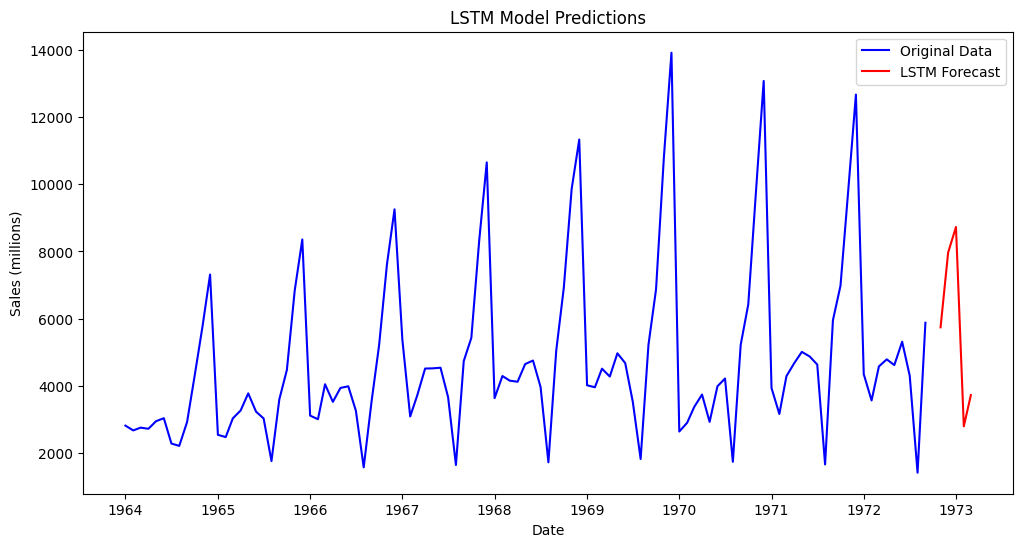

In [31]:
# Prepare the data for plotting
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Original Data', color='blue')
# plt.plot(df.index[:len(train_predict)], train_predict, label='Training Predictions', color='orange')
# plt.plot(df.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict, label='Test Predictions', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='M')[1:], forecast_lstm, label='LSTM Forecast', color='red')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Sales (millions)')
plt.legend()
plt.show()

In [67]:
# Inverse transform to get the original scale
forecast_values_lstm = scaler.inverse_transform(np.array(forecast_lstm).reshape(-1, 1))

print("LSTM Forecast:", forecast_values_lstm.flatten())


LSTM Forecast: [7.15181200e+07 9.85961920e+07 1.00895976e+08 3.64138080e+07
 4.88310480e+07]


In [68]:
# Assuming 'data' is your original DataFrame containing the sales data
# Correctly split into train and test sets
train_size = int(len(df) * 0.8)
train = df.iloc[0:train_size]  # Use iloc for indexing
test = df.iloc[train_size:]     # Ensure this remains a DataFrame


In [62]:
print(type(train))  # Should output <class 'pandas.core.frame.DataFrame'>
print(type(test))   # Should output <class 'pandas.core.frame.DataFrame'>


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [63]:
# Actual values from the test set
if 'Sales' in test.columns:
    actual_values = test['Sales'].values
else:
    print("Error: 'Sales' column not found in test DataFrame.")


## Choosing the best fitted model using RMSE(Root Mean Square Error)

In [33]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame with a 'Sales' column
# Check if 'df' is indeed a DataFrame
if not isinstance(df, pd.DataFrame):
    raise ValueError("The data variable must be a pandas DataFrame.")

# Split into train and test sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Ensure 'Sales' column exists in both train and test
if 'Sales' not in train.columns or 'Sales' not in test.columns:
    raise ValueError("'Sales' column must exist in both train and test DataFrames.")

# Fit the SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarima = model_sarima.fit()

# Generate forecasts for the length of the test set
forecast_values_SARIMA = fit_sarima.get_forecast(steps=len(test))
forecast_values_SARIMA = forecast_values_SARIMA.predicted_mean  # Extract the predicted means

# Fit the Holt-Winters model
model_holt = ExponentialSmoothing(train['Sales'], seasonal='mul', seasonal_periods=12).fit()
forecast_values_holt = model_holt.forecast(steps=len(test))

# Prepare LSTM Model
# Assuming you have a fitted LSTM model named model_lstm and a scaler for inverse transformation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train['Sales'].values.reshape(-1, 1))
scaled_test = scaler.transform(test['Sales'].values.reshape(-1, 1))

# Create the input for the LSTM model
X_test = []
for i in range(len(scaled_test) - 1):  # Adjust if your timesteps are different
    X_test.append(scaled_test[i:i + 1])  # Taking 1 timestep for prediction
X_test = np.array(X_test)

# Make predictions
# Ensure we predict for the correct length
forecast_values_lstm = model_lstm.predict(X_test)

# Inverse transform to get the original scale
forecast_values_lstm = scaler.inverse_transform(forecast_values_lstm.reshape(-1, 1))

# Make sure we get the last prediction if we're using sliding window
if len(forecast_values_lstm) < len(test):
    # Get the last value from the previous predictions
    last_value = scaled_test[-1]
    # Append the last value for the forecast
    forecast_values_lstm = np.append(forecast_values_lstm, scaler.inverse_transform(last_value.reshape(-1, 1)))

# Calculate RMSE
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Actual values from the test set
actual_values = test['Sales'].values

# Ensure forecast lengths match
if len(actual_values) != len(forecast_values_SARIMA):
    raise ValueError("Length of actual values does not match length of SARIMA forecasts.")
if len(actual_values) != len(forecast_values_holt):
    raise ValueError("Length of actual values does not match length of Holt-Winters forecasts.")
if len(actual_values) != len(forecast_values_lstm):
    raise ValueError("Length of actual values does not match length of LSTM forecasts.")

# Calculate RMSE for SARIMA, Holt-Winters, and LSTM
rmse_sarima = rmse(actual_values, forecast_values_SARIMA)
rmse_holt = rmse(actual_values, forecast_values_holt)
rmse_lstm = rmse(actual_values, forecast_values_lstm)

print(f"SARIMA RMSE: {rmse_sarima}")
print(f"Holt-Winters RMSE: {rmse_holt}")
print(f"LSTM RMSE: {rmse_lstm}")

# Compare models based on RMSE
best_model = min([('SARIMA', rmse_sarima), ('Holt-Winters', rmse_holt), ('LSTM', rmse_lstm)], key=lambda x: x[1])
print(f"Best Model: {best_model[0]} with RMSE: {best_model[1]}")


/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93100D+00    |proj g|=  1.67740D-01

At iterate    5    f=  6.85234D+00    |proj g|=  9.72166D-03

At iterate   10    f=  6.84740D+00    |proj g|=  1.73607D-02

At iterate   15    f=  6.84465D+00    |proj g|=  5.11902D-03

At iterate   20    f=  6.84459D+00    |proj g|=  7.61702D-04

At iterate   25    f=  6.84192D+00    |proj g|=  1.64221D-02

At iterate   30    f=  6.83075D+00    |proj g|=  4.76119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/4.2.5/libexec/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Model Comparison and Conclusion

Based on the **RMSE** values from the different models, the **Holt-Winters Exponential Smoothing** model outperforms both the **SARIMA** and **LSTM** models. The **Holt-Winters** model achieves an RMSE of **766.53**, significantly lower than the **SARIMA** model's RMSE of **1187.83** and the **LSTM** model's RMSE of **1130.69**. Given its lower RMSE, the **Holt-Winters model** provides the best predictive performance and is thus selected as the most reliable model for this time series forecasting task.
